In [1]:
import sys
sys.path.append('../../')

from modules.config import read_config

import modules.plots as plots
import torch
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
DIR = "./"
experiment_names = ["sinusmodel-sigma025", "sinusmodel-sigma05", "sinusmodel-sigma1", "sinusmodel-sigma2", "sinusmodel-sigma4"]
model_names = ["no-layer-sin", "one-layer-sin", "two-layer-sin", "three-layer-sin", "four-layer-sin", "five-layer-sin"]

In [27]:
exp = {}

for e in experiment_names:
    d = f"{DIR}/{e}"
    # Get all models
    subfolders = [ f.name for f in os.scandir(f"{d}/models") if f.is_dir() ]
    #Import train stats and results
    stats = {}
    for f in subfolders:
        with open(f"{d}/models/{f}/train_stats.json", "r") as file:
            stats[f] = json.load(file)


    # Get all results
    subfolders = [ f.name for f in os.scandir(f"{d}/results") if f.is_dir() ]
    res = {}
    for f in subfolders:
        with open(f"{d}/results/{f}/results.json", "r") as file:
            res[f] = json.load(file)

    exp[e] = {"stats": stats, "res": res}

In [52]:
print(experiment_names)
print(list(exp[experiment_names[0]].keys()))
print(model_names)
print(list(exp[experiment_names[0]]["stats"][model_names[0]].keys()))
print(list(exp[experiment_names[0]]["res"][model_names[0]].keys()))
print(list(exp[experiment_names[0]]["res"][model_names[0]]["test_error"].keys()))


['sinusmodel-sigma025', 'sinusmodel-sigma05', 'sinusmodel-sigma1', 'sinusmodel-sigma2', 'sinusmodel-sigma4']
['stats', 'res']
['no-layer-sin', 'one-layer-sin', 'two-layer-sin', 'three-layer-sin', 'four-layer-sin', 'five-layer-sin']
['elbo_minibatch', 'elbo_epoch', 'val_rmse_epoch', 'train_rmse', 'time']
['test_error', 'in_domain_error', 'out_domain_error', 'predictive', 'predictive_in_domain', 'predictive_out_domain']
['rmse', 'mae']


In [29]:
### Elbo

In [30]:
def compare_elbo(stats, names, figsize=(15, 6), title=""):
    fig, ax = plt.subplots(figsize=figsize)
    for name in names:
        ax.plot(stats[name]["elbo_epoch"], label=name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Train - ELBO")
    ax.set_ylim(0, 2e5)
    ax.set_title(title)
    ax.legend()
    plt.show()

def compare_rmse(stats, names, figsize=(15, 6), title=""):
    fig, ax = plt.subplots(figsize=figsize)
    for name in names:
        ax.plot(stats[name]["val_rmse_epoch"], label=name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Val - RMSE")
    ax.set_title(title)
    ax.legend()
    plt.show()

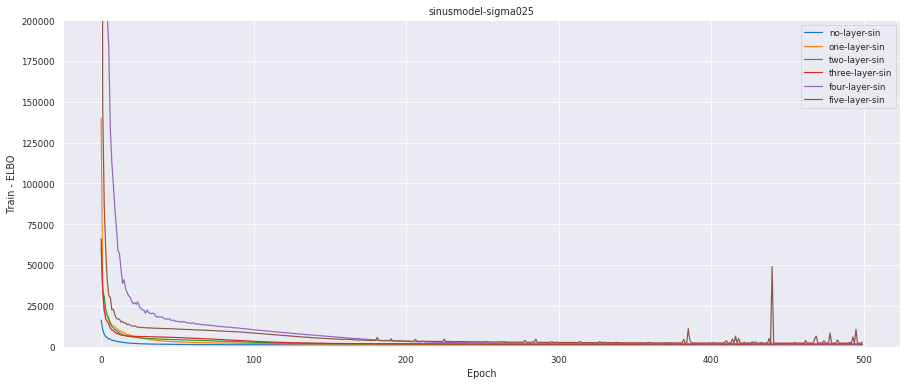

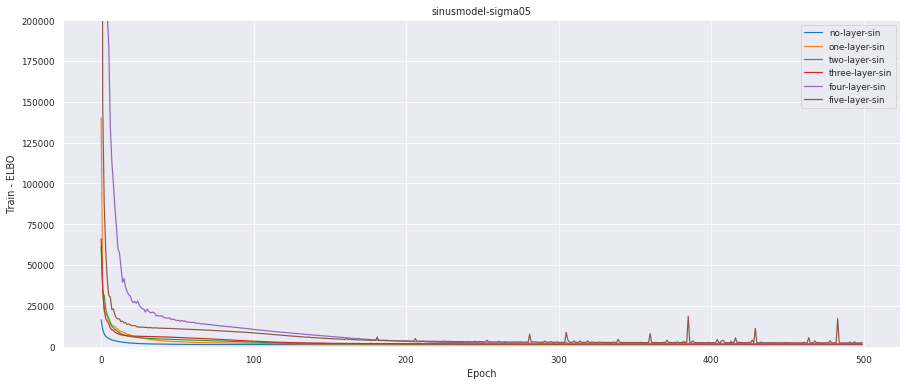

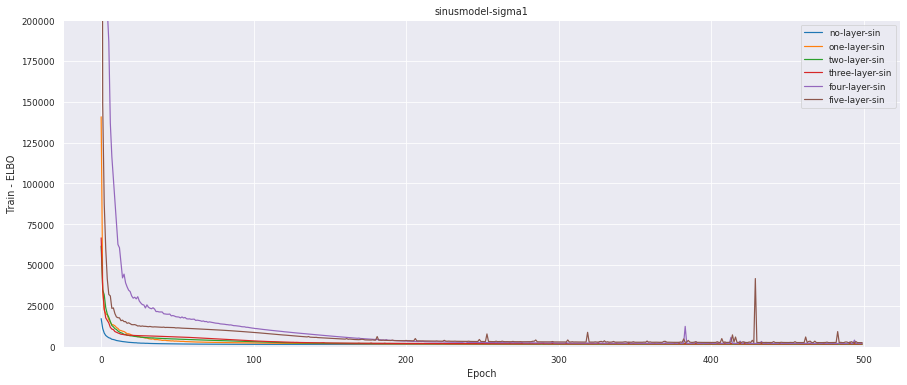

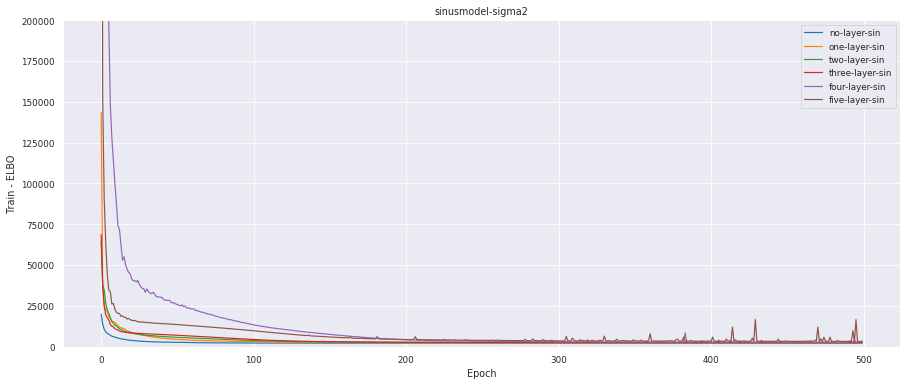

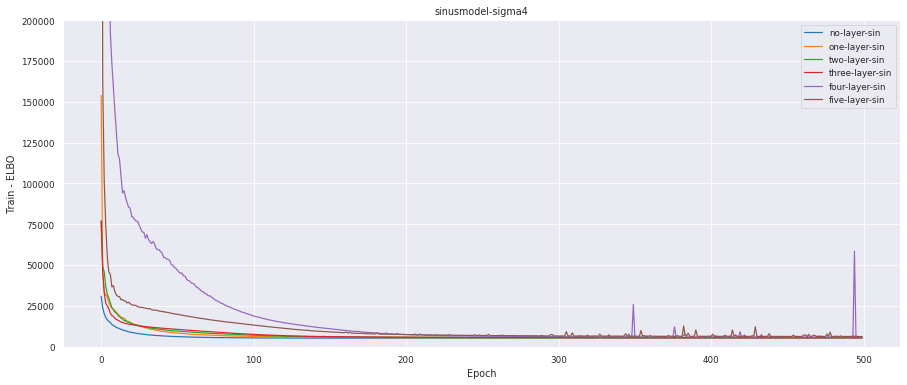

In [31]:
for e in experiment_names:
    compare_elbo(exp[e]["stats"], model_names, figsize=(15, 6), title=e)

In [32]:
### RMSE

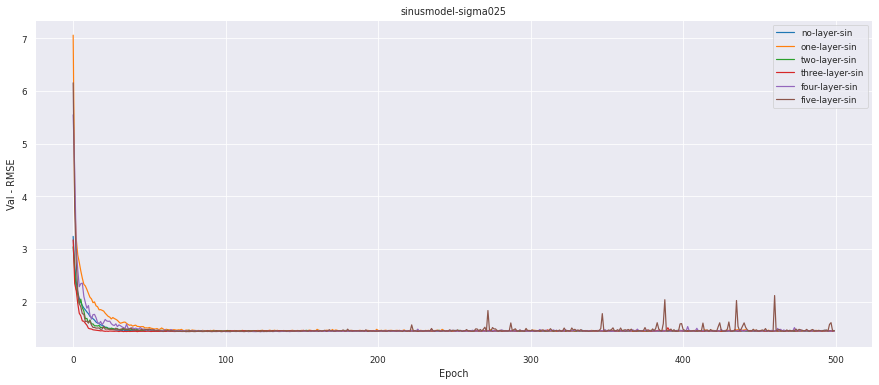

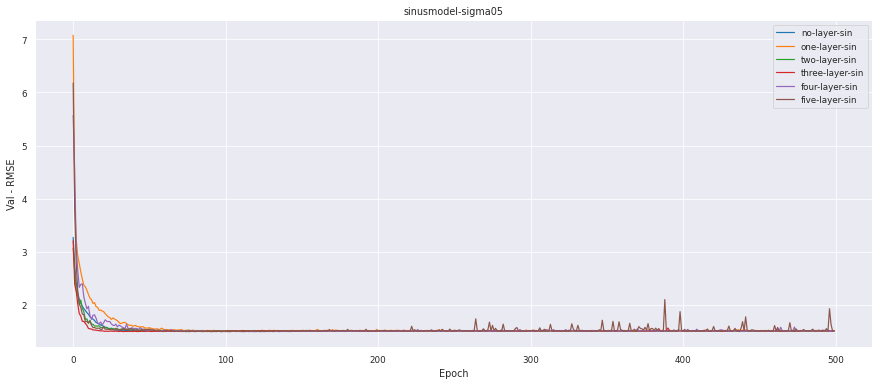

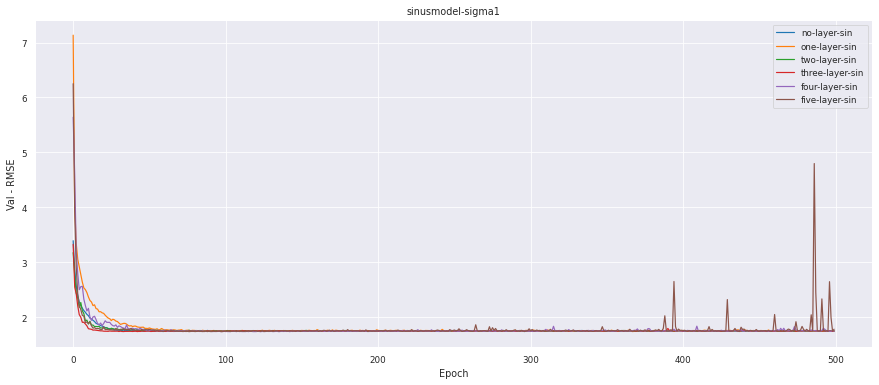

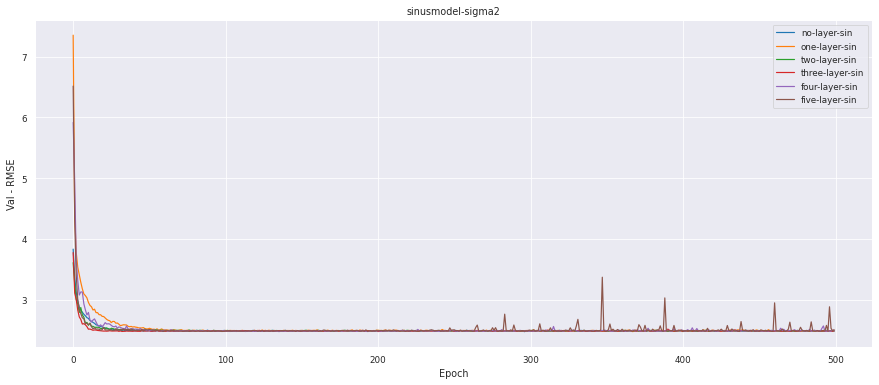

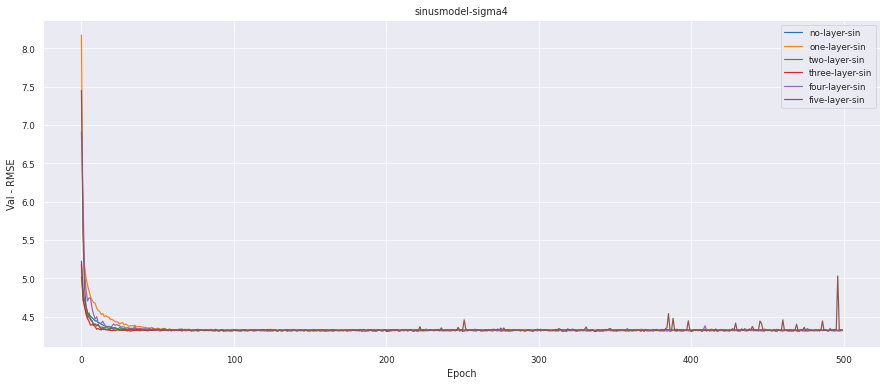

In [33]:
for e in experiment_names:
    compare_rmse(exp[e]["stats"], model_names, figsize=(15, 6), title=e)

In [34]:
def compare_models(stats, names, metric, xlabel="", ylabel="", fig_size=(10, 8), ax=None, title=""):
    rmse = [stats[k][metric] for k in names]

    if ax is None:
        sns.set_style("darkgrid")
        sns.set_context("paper")
        fig, ax = plt.subplots(figsize=fig_size)

    sns.lineplot(
    x=names, y=rmse, ax=ax)
    sns.scatterplot(
    x=names, y=rmse, marker="s", s=100,
    ax=ax)

    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    ax.set_title(title)


def compare_models_experiments(experiment_names, model_names, metric, xlabel="", ylabel="", fig_size=(10, 8), title=""):
    sns.set_style("darkgrid")
    sns.set_context("paper")
    fig, ax = plt.subplots(figsize=fig_size)
    
    for e in experiment_names:
        stats = exp[e]["stats"]
        compare_models(stats, model_names, metric, xlabel, ylabel, fig_size, ax, title)

    ax.legend(experiment_names)

    plt.show()
    
    
        

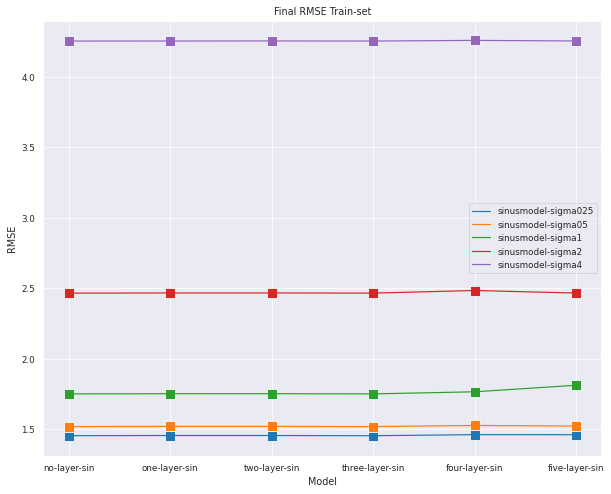

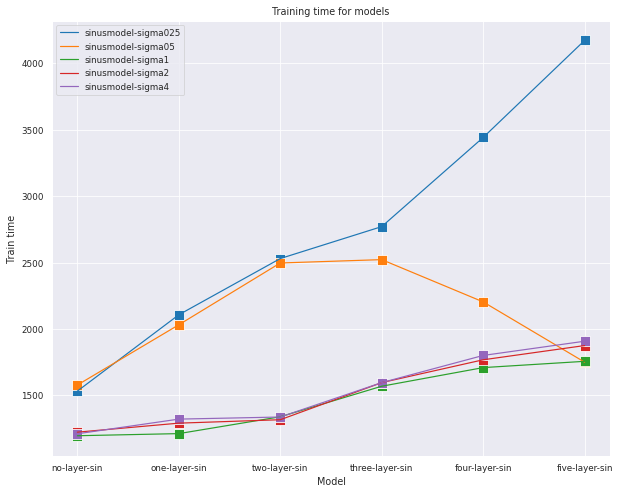

In [35]:
compare_models_experiments(experiment_names, model_names, "train_rmse", xlabel="RMSE", ylabel="Model", fig_size=(10, 8), title="Final RMSE Train-set")
compare_models_experiments(experiment_names, model_names, "time", xlabel="Train time", ylabel="Model", fig_size=(10, 8), title="Training time for models")

In [39]:
### Results - Test

In [40]:
keys = list(res.keys())
print(keys)
print(res[keys[0]].keys())
print(res[keys[0]]["test_error"].keys())
print(res[keys[0]]["predictive"].keys())

['five-layer-sin', 'two-layer-sin', 'one-layer-sin', 'three-layer-sin', 'no-layer-sin', 'four-layer-sin']
dict_keys(['test_error', 'in_domain_error', 'out_domain_error', 'predictive', 'predictive_in_domain', 'predictive_out_domain'])
dict_keys(['rmse', 'mae'])
dict_keys(['kl_div', 'mean_diff', 'std_diff'])


In [87]:
def compare_model_error(res, names, domain, fig_size=(20, 8), ax=None):
    results = [res[k][domain] for k in names]
    rmse = [r["rmse"] for r in results]
    mae = [r["mae"] for r in results]

    if ax is None:
        sns.set_style("darkgrid")
        sns.set_context("paper")
        fig, ax = plt.subplots(1, 2, figsize=fig_size)
    
    sns.lineplot(
    x=names, y=rmse, ax=ax[0])
    sns.scatterplot(
    x=names, y=rmse, marker="s", s=100,
    ax=ax[0])
    ax[0].set_ylabel(f"{domain} - RMSE")
    ax[0].set_xlabel("Model")

    sns.lineplot(
    x=names, y=mae, ax=ax[1])
    sns.scatterplot(
    x=names, y=mae, marker="s", s=100,
    ax=ax[1])
    ax[1].set_ylabel(f"{domain} - MAE")
    ax[1].set_xlabel("Model")

def compare_model_results(res, names, domain, fig_size=(12, 12), ax=None):
    results = [res[k][domain] for k in names]
    kl_div = [r["kl_div"] for r in results]
    mean_diff = [r["mean_diff"] for r in results]
    std_diff = [r["std_diff"] for r in results]

    if ax is None:
        sns.set_style("darkgrid")
        sns.set_context("paper")
        fig, ax = plt.subplots(1, 3, figsize=fig_size)

    
    sns.lineplot(
    x=names, y=kl_div, ax=ax[0])
    sns.scatterplot(
    x=names, y=kl_div, marker="s", s=100,
    ax=ax[0])
    ax[0].set_ylabel(f"{domain} - KL Divergence")
    ax[0].set_xlabel("Model")

    sns.lineplot(
    x=names, y=mean_diff, ax=ax[1])
    sns.scatterplot(
    x=names, y=mean_diff, marker="s", s=100,
    ax=ax[1])
    ax[1].set_ylabel(f"{domain} - Mean Diff")
    ax[1].set_xlabel("Model")

    sns.lineplot(
    x=names, y=std_diff, ax=ax[2])
    sns.scatterplot(
    x=names, y=std_diff, marker="s", s=100,
    ax=ax[2])
    ax[2].set_ylabel(f"{domain} - Std Diff")
    ax[2].set_xlabel("Model")

def compare_model_error_experiments(experiment_names, model_names, domain, fig_size=(20, 8), title=""):
    sns.set_style("darkgrid")
    sns.set_context("paper")
    fig, ax = plt.subplots(1, 2, figsize=fig_size)
    
    for e in experiment_names:
        res = exp[e]["res"]
        compare_model_error(res, model_names, domain, fig_size, ax)

    ax[0].legend(experiment_names)
    ax[1].legend(experiment_names)

    fig.suptitle(title)

    plt.show()

def compare_model_results_experiments(experiment_names, model_names, domain, fig_size=(12, 12), title=""):
    sns.set_style("darkgrid")
    sns.set_context("paper")
    fig, ax = plt.subplots(1, 3, figsize=fig_size)
    
    for e in experiment_names:
        res = exp[e]["res"]
        compare_model_results(res, model_names, domain, fig_size, ax)

    ax[0].legend(experiment_names)
    ax[1].legend(experiment_names)
    ax[2].legend(experiment_names)

    fig.suptitle(title)

    plt.show()
    

In [88]:
### Likeness of predictive distribution

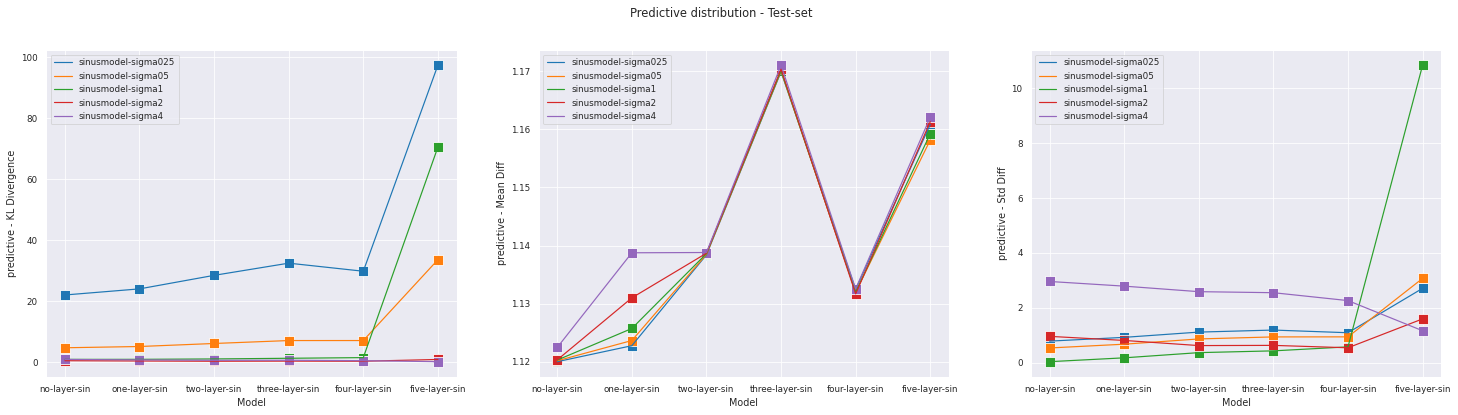

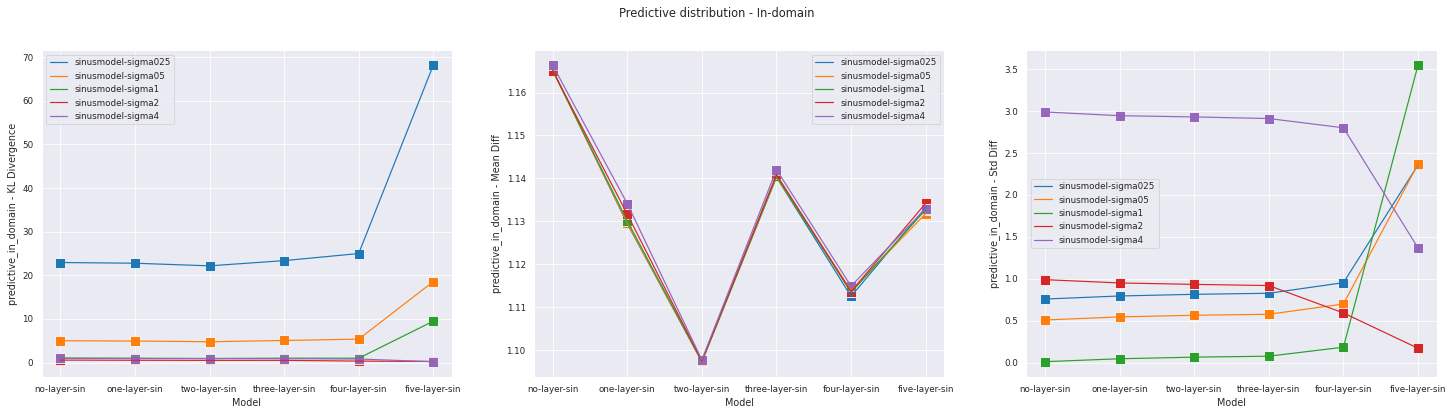

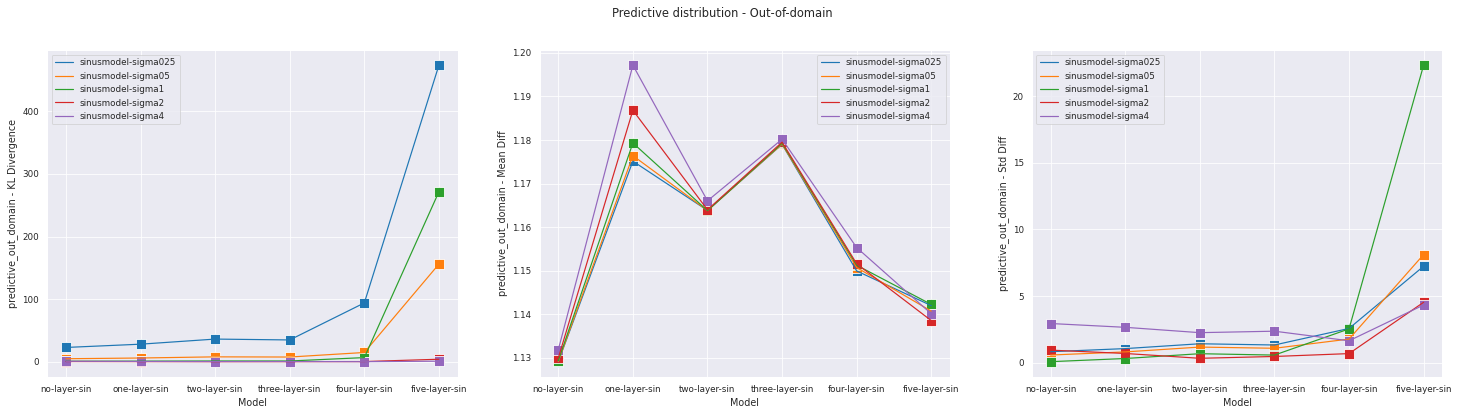

In [89]:
compare_model_results_experiments(experiment_names, model_names, "predictive", fig_size=(25, 6), title="Predictive distribution - Test-set")
compare_model_results_experiments(experiment_names, model_names, "predictive_in_domain", fig_size=(25, 6), title="Predictive distribution - In-domain")
compare_model_results_experiments(experiment_names, model_names, "predictive_out_domain", fig_size=(25, 6), title="Predictive distribution - Out-of-domain")

In [ ]:
### Test Error

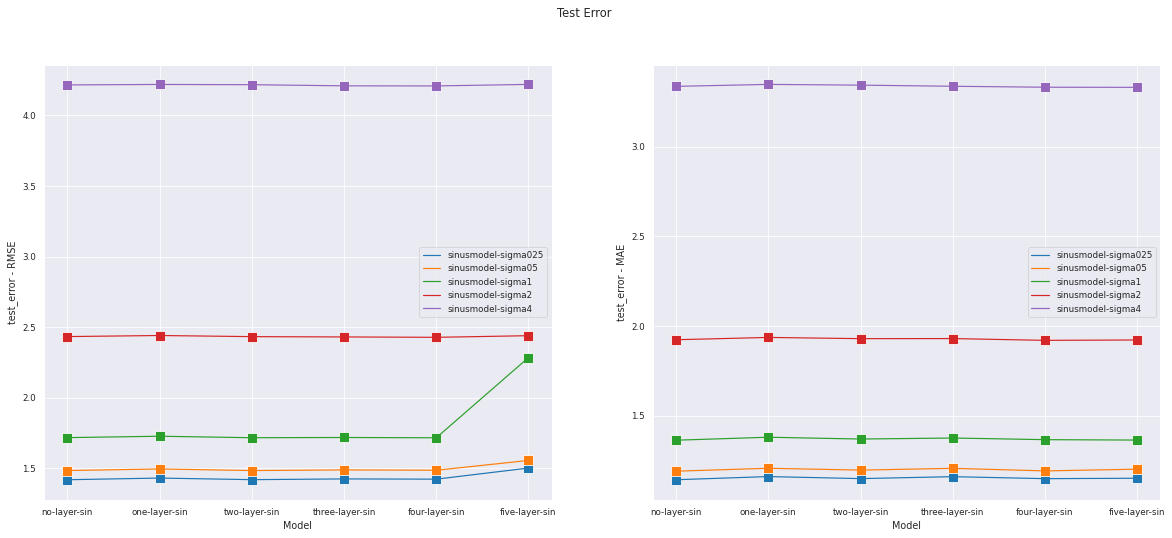

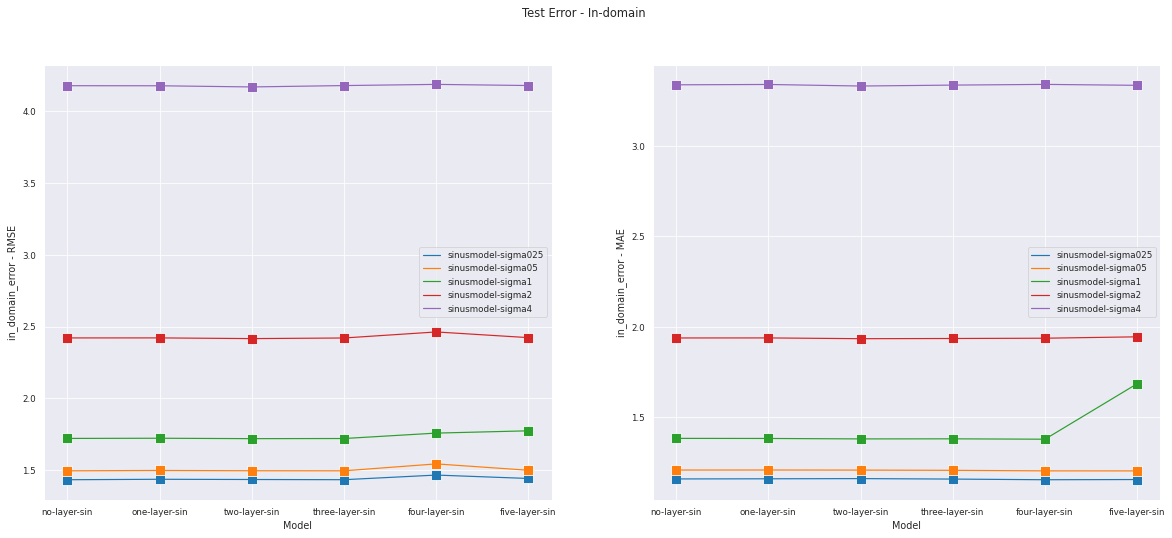

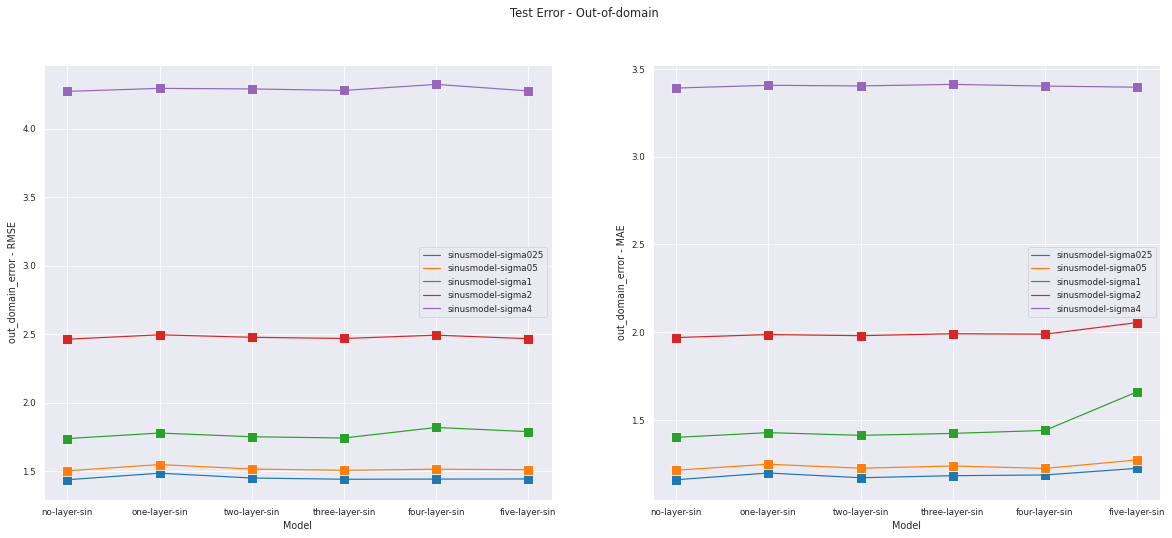

In [92]:
compare_model_error_experiments(experiment_names, model_names, "test_error", fig_size=(20, 8), title="Test Error")
compare_model_error_experiments(experiment_names, model_names, "in_domain_error", fig_size=(20, 8), title="Test Error - In-domain")
compare_model_error_experiments(experiment_names, model_names, "out_domain_error", fig_size=(20, 8), title="Test Error - Out-of-domain")